In [58]:
%run convergence.py
%run clockwork_axion.py

In [82]:
N = 10
m_phi_range = np.geomspace(1e-6, 1e6, N + 1) * 1e-9 # [GeV]
mR_range = np.linspace(1, 15, N)
sim_f_eff = f_eff = 1e13
H_inf = 1e8
Gamma_inf = H_inf

In [85]:
def fn(m_phi, mR, i, j, debug=False):
    eps = calc_eps(mR)
    f = calc_f(f_eff, eps)
    M = m_phi / eps
    ax0 = (theta_to_phi_over_f(1.0, eps), 0.0)
    n = i + j * len(m_phi_range) + 1
    print("step:", n, "of", len(m_phi_range) * len(mR_range), end="")
    start = time.time()
    try:
        x = compute_asymmetry(H_inf, Gamma_inf, (eps, M), f, 
            clockwork_axion_field, axion_init=ax0, calc_init_time=True, debug=debug, convergence_rtol=0.001)
    except ValueError:
        x = np.nan
    end = time.time()
    print(" done (%f seconds)" % (end - start))
    return x

In [91]:
%time eta = np.array([[fn(m_phi, mR, i, j) for i, m_phi in enumerate(m_phi_range)] for j, mR in enumerate(mR_range)])

step: 1 of 110 done (11.820657 seconds)
step: 2 of 110 done (10.600957 seconds)
step: 3 of 110 done (11.065612 seconds)
step: 4 of 110 done (4.160973 seconds)
step: 5 of 110 done (4.062137 seconds)
step: 6 of 110 done (4.023312 seconds)
step: 7 of 110 done (3.749894 seconds)
step: 8 of 110 done (3.703700 seconds)
step: 9 of 110 done (3.640684 seconds)
step: 10 of 110 done (3.533981 seconds)
step: 11 of 110 done (3.318205 seconds)
step: 12 of 110 done (3.013260 seconds)
step: 13 of 110 done (3.430171 seconds)
step: 14 of 110 done (3.563429 seconds)
step: 15 of 110 done (3.327642 seconds)
step: 16 of 110 done (3.112338 seconds)
step: 17 of 110 done (3.290340 seconds)
step: 18 of 110 done (3.847811 seconds)
step: 19 of 110 done (4.340562 seconds)
step: 20 of 110 done (4.171236 seconds)
step: 21 of 110 done (3.455854 seconds)
step: 22 of 110 done (3.299929 seconds)
step: 23 of 110 done (3.929840 seconds)
step: 24 of 110 done (4.132710 seconds)
step: 25 of 110 done (3.416817 seconds)
step: 

<timed exec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


<ipython-input-109-60c6f71d7950>:2: RuntimeWarning: invalid value encountered in log10
  plt.contour(m_phi_range * 1e9, mR_range, np.log10(eta / eta_observed))


Text(0, 0.5, 'mR')

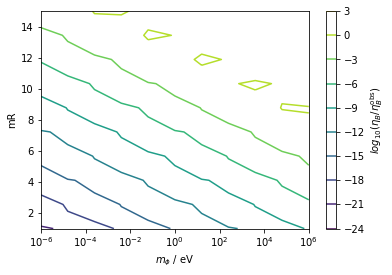

In [109]:
eta_observed = 6e-10 # from paper
plt.figure()
plt.contour(m_phi_range * 1e9, mR_range, np.log10(eta / eta_observed))
plt.xscale("log")
plt.colorbar(label=r"$log_{10}(\eta_B / \eta_B^\mathrm{obs})$")
plt.xlabel(r"$m_\phi$ / eV")
plt.ylabel(r"mR")

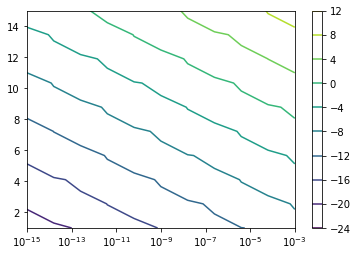

In [118]:
plt.contour(m_phi_range, mR_range, np.log10(m_phi_range[None, :] / calc_eps(mR_range[:, None]) / H_inf))
plt.xscale("log")
plt.colorbar()

step: 1 of 110step = 1
calculcated initial integration time:
tmax_inf_time = 36.383959044106305 tmax_axion_time = 3.638395904410631e-22
rh: 0.19576454162597656
axion: 0.008235931396484375
transport eq.: 0.17962193489074707
change by timescale: 1.965020009353022e+21 vs 0.015
B-L range: -9.542583116397547e-53 0.0
delta = 4.274660746759879 convergence_rtol = 0.015
step = 2


/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:46: RuntimeWarning: divide by zero encountered in true_divide
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)
/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)


rh: 0.16579532623291016
axion: 0.012176990509033203
transport eq.: 0.3851964473724365
change by timescale: 0.1629268254097758 vs 0.015
B-L range: -1.7412871029331615e-39 9.786388215151657e-41
delta = 115.4418487805056 convergence_rtol = 0.015
step = 3
rh: 0.015790462493896484


/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:12: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(rho_field + rho_rad) * C


axion: 0.24981307983398438
transport eq.: 1.188671588897705
change by timescale: 0.031222182961468736 vs 0.015
B-L range: -3.186258499994243e-30 1.6550960459577808e-35
delta = 29.949692263967076 convergence_rtol = 0.015
step = 4
rh: 0.014425992965698242
axion: 0.19573688507080078
transport eq.: 1.2092299461364746
change by timescale: 0.009093676410338276 vs 0.015
B-L range: -2.0676783882941364e-30 -9.335945405417126e-31
delta = 0.8385554659191321 convergence_rtol = 0.015
step = 5
rh: 0.013713836669921875
axion: 0.18021678924560547
transport eq.: 1.373366355895996
change by timescale: 0.0455399427351871 vs 0.015
B-L range: -1.7317962059930025e-30 -1.1170393677445968e-30
delta = 0.5340078695896572 convergence_rtol = 0.015
step = 6
rh: 0.014643430709838867
axion: 0.17887592315673828
transport eq.: 1.3850715160369873
change by timescale: 0.0007448913047057304 vs 0.015
B-L range: -2.1893971607794097e-30 -1.7009813268828067e-30
delta = 0.27897788596971423 convergence_rtol = 0.015
step = 7
rh

/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)
/home/jana/Documents/masters-project/transport_eq_in_time/decay_process.py:46: RuntimeWarning: divide by zero encountered in true_divide
  T_dot = np.where(T == 0, np.inf, T_dot_const * (Gamma * rho_field - 4*H*rho_rad) / T**3)
No handles with labels found to put in legend.


 done (26.267522 seconds)


(1, 4.833874432263115e-32)

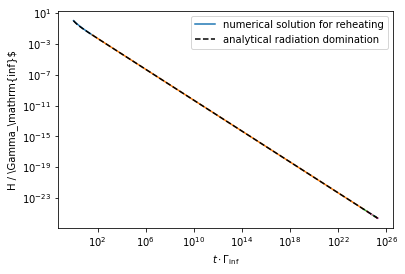

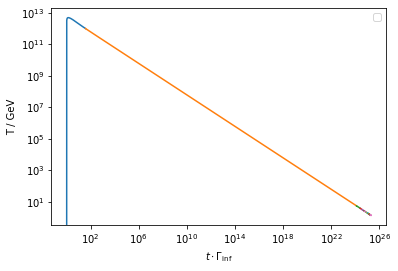

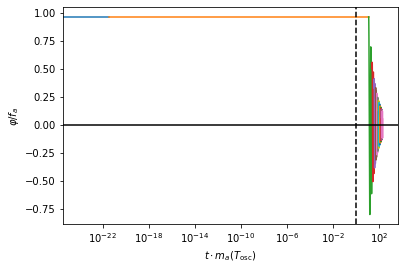

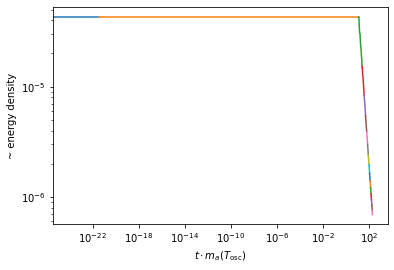

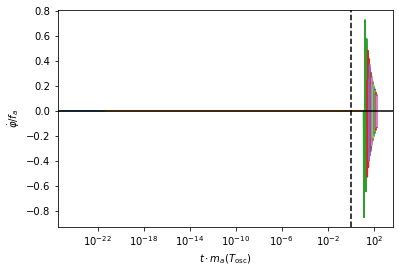

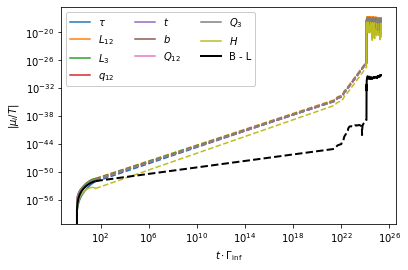

In [75]:
fn(m_phi_range[0], mR_range[0], 0, 0, True)